In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#sofr 대체금리 (3개월물 데이터를 불러옴)
sofr = pd.read_excel('sofr.xlsx', index_col=0)
sofr.index = pd.to_datetime(sofr.index)
sofr.head()

C:\Users\siro8458\AppData\Local\Temp\ipykernel_14508\1849924.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


,Rate (%),1st Percentile (%),25th Percentile (%),75th Percentile (%),99th Percentile (%),Volume ($Billions)
Date,,,,,,
2021-01-04,0.10,0.05,0.07,0.12,0.17,1046
2021-01-05,0.11,0.06,0.08,0.13,0.18,986
2021-01-06,0.10,0.07,0.08,0.13,0.18,978
2021-01-07,0.10,0.06,0.08,0.12,0.18,951
2021-01-08,0.09,0.06,0.07,0.12,0.17,992


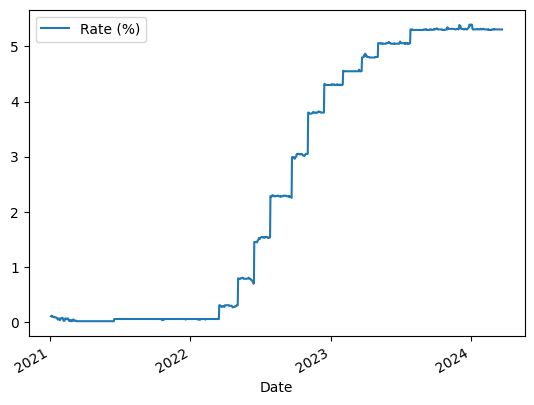

In [2]:
sofr.iloc[:, :1].plot()
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_major_locator(mdates.YearLocator())
plt.show()

In [3]:
import numpy as np

t = sofr.index.to_pydatetime() #날짜들
f = sofr.iloc[:, :1].values / 100

#dx 패키지의 선도금리를 이용 못해서, 선형의 선도를 가정
def linear_forward(para, dates):
    k, b = para
    return k * np.array([(date - dates[0]).days for date in dates]) + b #선형 덧셈 가정

def mse(params, rates, dates): #rates 는 sofr 의 이자율
    model = linear_forward(params, dates)
    return np.mean((rates - model)**2)
    
#처음 기울기와 y절편을 0.001, 0.01 로 가정
initial = [0.001, 0.01]

from scipy.optimize import fmin

#fmin 이용 최적화 수행
opt = fmin(mse, initial, args=(f, t), maxiter=1000, maxfun=1000)

#최적화 파라미터 기반, 직접 선도 금리 계산
opt_rate = linear_forward(opt, t)

Optimization terminated successfully.
         Current function value: 0.000526
         Iterations: 43
         Function evaluations: 82


In [4]:
# 최적 파라미터는 아래와 같고, 이는 선형의 선도 금리를 가정하였기 때문이다.
opt

array([9.33807343e-08, 2.43507953e-02])

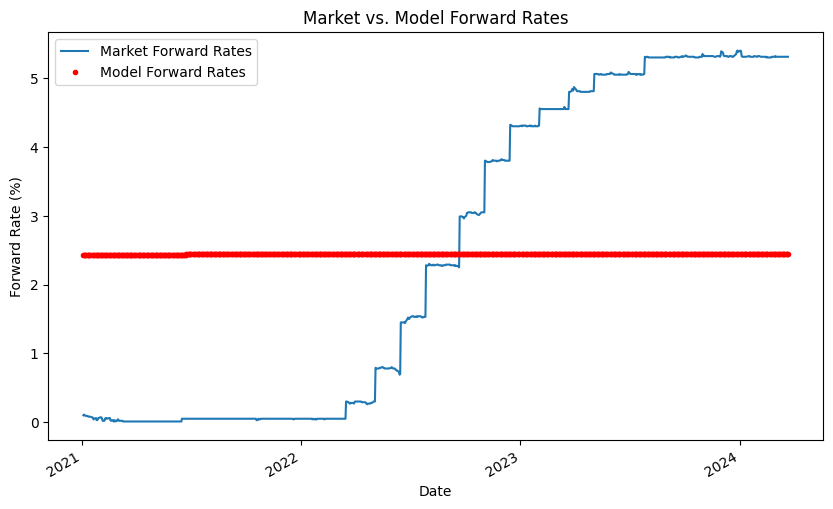

In [5]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(10, 6))
plt.plot(t, f * 100, label='Market Forward Rates')  # f 값을 백분율로 변환
plt.plot(t, opt_rate * 100, 'r.', label='Model Forward Rates')  # opt_rate 값을 백분율로 변환
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

plt.gcf().autofmt_xdate()  # 날짜 레이블이 겹치지 않도록 자동 조정
plt.legend(loc=0)  # 범례 위치 설정
plt.xlabel('Date')  # x축 레이블
plt.ylabel('Forward Rate (%)')  # y축 레이블
plt.title('Market vs. Model Forward Rates')  # 그래프 제목
plt.show()


# 랜덤 포레스트 이용 선도금리 모델링

In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def date_to_num(dates):
    return np.array([pd.Timestamp(date).toordinal() for date in dates])

X_rf = date_to_num(sofr.index).reshape(-1, 1)
y_rf = sofr['Rate (%)'].values  # 종속 변수

X_train, X_test, y_train, y_test = train_test_split(X_rf, y_rf, test_size=0.4, random_state=42)

# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_rf)

# 예측 성능 평가 (평균 제곱 오차)
mse_rf = mean_squared_error(y_rf, y_pred_rf)
print(f'Test MSE: {mse_rf}')

Test MSE: 0.0015514273507462708


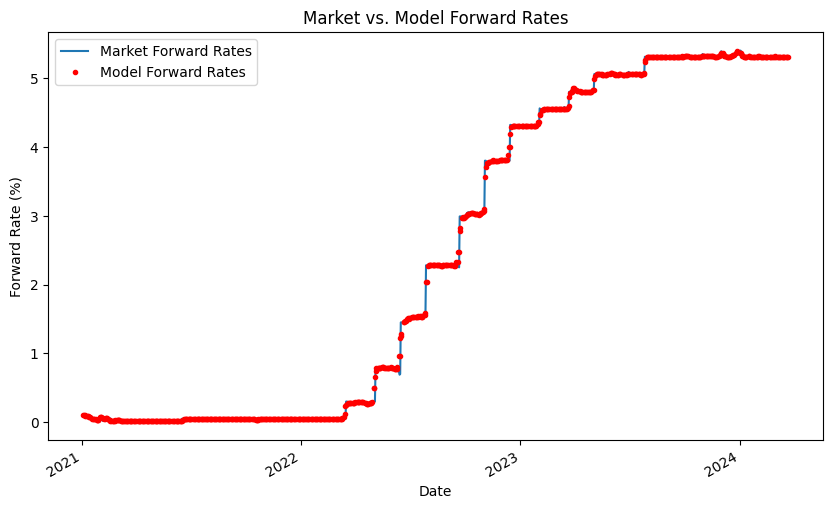

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(t, f * 100, label='Market Forward Rates')  # f 값을 백분율로 변환
plt.plot(t, y_pred_rf , 'r.', label='Model Forward Rates')  # opt_rate 값을 백분율로 변환
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

plt.gcf().autofmt_xdate()  # 날짜 레이블이 겹치지 않도록 자동 조정
plt.legend(loc=0)  # 범례 위치 설정
plt.xlabel('Date')  # x축 레이블
plt.ylabel('Forward Rate (%)')  # y축 레이블
plt.title('Market vs. Model Forward Rates')  # 그래프 제목
plt.show()

<io>
이제 이러한 방식으로 예측한 sofr 변동금리를 바탕으로, 션형 뿐만 아니라 랜덤포레스트로 예측된 변동금리도 활용하여 <br>
IRS 의 valuation을 30년 국채와 활용하여 해보고자 한다. <br>
할인율을 0.5%로 가정해 보고자 한다. (이는 실물경제에 따라서 변경하면 됨) <br>
(dx 패키지를 이용하는 것이 가장 모던하다고 하는데, 뭔가 설치할때 꼬여서.. 추후 추가해보도록 하겠다)

In [11]:
len(opt_rate)

804

In [10]:
len(y_pred_rf)

804

In [12]:
dis_rate = 0.005

fixed = pd.read_excel('fixed.xlsx', index_col=0)

In [28]:
rate1 = fixed.values - opt_rate #선형 예측
rate2 = fixed.values - y_pred_rf #랜덤포레스트

In [29]:
periods = np.arange(len(rate1)) #어차피 총 804개 이지만, 일별은 아니라, 따로 계산해야 하지만, 연속된 날짜로 가정해보겠다
# 즉 periods는 0부터 803까지의 값을 가진다.
dis_exp = np.exp(-dis_rate * periods) #discount 되어서 곱해질 값

In [31]:
#이제 이 2021.1.4~2024.3.21까지의 금리 값이 주어진 경우 IRS의 valuation은 NPV를 활용하면 된다
npv1 = np.sum(rate1/100 * dis_exp)
npv2 = np.sum(rate2/100 * dis_exp)
print(npv1, npv2)

8122.8917798665525 7219.276562549105
